# Likelihood Estimation

_Author: Valentin Pratz_

The likelihood function $p(x|\theta)$ describes the distribution of data $x$ conditional on parameters $\theta$.
While posterior estimation is the predominant use-case in BayesFlow, estimating likelihoods is possible as well.
There are two main motivations to approximate a likelihood.
First, one might want to estimate the _density_ of data $x$ for given parameters $\theta$, which is not possible if one only has access to a simulator.
Second, one might want to train an approximate _synthetic likelihood_ for faster sampling, leveraging the interpolation capacities of neural networks.

Doing likelihood estimatin instead of posterior estimation requires only minor modifications to the pipeline.
We will demonstrate the basic steps on a simple toy example below.
If you have an idea for a more interesting case study, please make a pull request or reach out to us.

## Toy Example

We will use a very simple toy example, a bi-modal distribution obtained by mirroring a two-dimensional Gaussian at the origin. For simplicity, we only use the mean as a parameter, and use a fixed diagonal covariance matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesflow as bf

rng = np.random.default_rng()

2025-05-29 19:34:45.282013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748547285.296109   67915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748547285.300706   67915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 19:34:45.316470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-29 19:34:47.337817: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [2]:
def likelihood(theta):
    loc = theta if rng.random() > 0.5 else -theta
    return {"x": rng.normal(loc=loc, scale=0.2, size=theta.shape)}

The likelihood $p(x|\theta)$ is conditional on $\theta$. As we know how we can produce as simulations, we can already look at samples from the likelihood for a given $\theta$. The simulator serves as an _implicit likelihood_. Below, we specify the simulator with a fixed parameter that is passed to the likelihood function. We can then sample from the likelihood, and plot the resulting samples.

In [3]:
theta_0 = np.array([1.0, 1.0])

def params():
    return {"theta": theta_0}

simulator = bf.make_simulator([params, likelihood])

In [4]:
sims = simulator.sample(5000)
sims["x"].shape

(5000, 2)

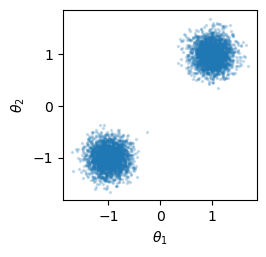

In [5]:
plt.figure(figsize=(2.5, 2.5))
plt.scatter(*sims["x"].T, s=2, alpha=0.2)
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")
plt.gca().set_aspect("equal", "box");

While we could use those samples to produce an estimation of the likelihood for this specific parameter value, we often want to obtain an estimation for a range of parameter values. Similar to the prior distribution in posterior estimation, we can specify a function that randomly produces parameter values we are interested in. As we estimate the likelihood $p(x|\theta)$, which is conditional on $\theta$, how this function looks like will not change the "ground truth" we aim to estimate. In contrast, changing the prior in posterior estimation also changes the true posterior.

In practice, different choices of this function can lead to different approximation results, as it determines how many simulations the approximator sees for each parameter region. Here, we choose a uniform distribution in the range from -2 to 2.

In [6]:
def params():
    theta = rng.uniform(-2, 2, (2,))
    return {"theta": theta}

simulator = bf.make_simulator([params, likelihood])

## Training

We are now ready to do the actual likelihood estimation. We want to learn the likelihood of the data $x$ conditional on the parameters $\theta$. Therefore, we use the parameters as `inference_conditions`, and the data as `inference_variables`. We do not use a summary network, so no `summary_conditions` are present. We can use a `BasicWorkflow`, which allows us to easily specify the necessary parameters.

`CouplingFlow`s are nice, because they enable fast sampling and likelihood evaluation, but they can struggle with multimodal distributions. Therefore, we will use a diffusion model here, at the cost of largely increased inference time. What one would choose in practice depends on the constraints regarding speed and accuracy. Note that accurate likelihood approximation can require a lot of training samples, especially when the distributions are complex and high-dimensional.

In [7]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    inference_network=bf.experimental.DiffusionModel(),
    inference_variables="x",
    inference_conditions="theta",
    initial_learning_rate=1e-3
)

In [8]:
history = workflow.fit_online(epochs=30, num_batches_per_epoch=500, batch_size=64, validation_data=1024)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.1271 - loss/inference_loss: 2.1271 - val_loss: 4.5580 - val_loss/inference_loss: 4.5580
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7357 - loss/inference_loss: 1.7357 - val_loss: 1.1092 - val_loss/inference_loss: 1.1092
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4519 - loss/inference_loss: 1.4519 - val_loss: 1.1577 - val_loss/inference_loss: 1.1577
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2933 - loss/inference_loss: 1.2933 - val_loss: 1.6165 - val_loss/inference_loss: 1.6165
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1346 - loss/inference_loss: 1.1346 - val_loss: 3.3525 - val_loss/inference_loss: 3.3525
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1996 - loss/inference_loss: 1.1996 - val_loss: 1.8124 - val_loss/inference_loss: 1.8124
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1846 - loss/inference_loss: 1.1846 - v

## Evaluation

We can now sample from the approximate likelihood by specifying $\theta$ as the condition.

In [9]:
%%time
approx_samples = workflow.sample(num_samples=5000, conditions={"theta": theta_0[None]})

CPU times: user 1min 15s, sys: 27.6 s, total: 1min 43s
Wall time: 16.8 s


In [10]:
approx_samples['x'].shape

(1, 5000, 2)

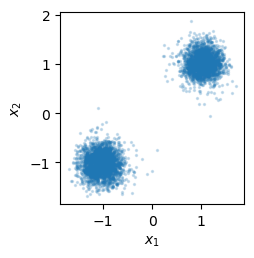

In [11]:
plt.figure(figsize=(2.5, 2.5))
plt.scatter(*approx_samples["x"][0].T, s=2, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal", "box");

You might have noticed that we could already sample before training, as we needed this to actually train our model.
Now, with the trained model, we can evaluate the likelihood density as well, which was not possible before.
Below, we make a two-dimensional plot of the density for a given set of parameters.

In [12]:
%%time
nx_1, nx_2 = (25, 25)
x_1 = np.linspace(-2, 2, nx_1)
x_2 = np.linspace(-2, 2, nx_2)
vx_1, vx_2 = np.meshgrid(x_1, x_2)
xvals = np.stack([np.reshape(vx_1, (-1,)), np.reshape(vx_2, (-1,))], axis=-1)

log_density = workflow.log_prob(data={"x": xvals, "theta": np.repeat(theta_0[None], xvals.shape[0], axis=0)})

CPU times: user 35.9 s, sys: 2.82 s, total: 38.8 s
Wall time: 12.9 s


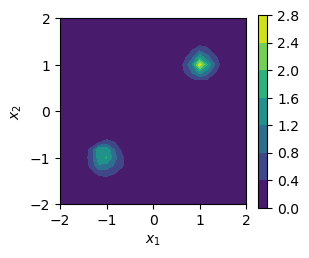

In [13]:
fig = plt.figure(figsize=(3,2.5))
plt.contourf(x_1, x_2, np.reshape(np.exp(log_density), (nx_1, nx_2)))
plt.gca().set_aspect("equal", "box")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar()
plt.show()

## Further Steps

In this notebook, we presented the fundamentals of likelihood estimation with BayesFlow, but did not go into much detail regarding training details or network architectures.
In practice, we advise to start with a simpler inference network like `CouplingFlow`s, and a moderate amount of training samples.
To improve performance, you can experiment with hyperparameters (learning rate, batch size, epochs, ...), and, depending on your setting, increase the number of training samples or move to a slower but more expressive architecture like `FlowMatching` or `DiffusionModel`.